# TensorFlow

**[OCE-01]** 必要なモジュールをインポートして、乱数のシードを設定します。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle

np.random.seed(20160703)
tf.set_random_seed(20160703)

/Users/yohei/.pyenv/versions/anaconda3-5.0.0/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**[OCE-02]** データファイル「ORENIST.data」から画像とラベルのデータを読み込みます。

In [2]:
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file, encoding='latin1')

**[OCE-03]** フィルターの情報を格納した多次元リストを作る関数を用意します。

In [3]:
def edge_filter():
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5,5,1,2]) # FH, FW, C, FN
    filter_array[:,:,0,0] = filter0
    filter_array[:,:,0,1] = filter1

    return tf.constant(filter_array, dtype=tf.float32)

**[OCE-04]** 画像データにフィルターとプーリング層を適用する計算式を用意します。

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 784])
x_image = tf.reshape(x, [-1,28,28,1]) # N, H, W, C

W_conv = edge_filter()
h_conv = tf.abs(tf.nn.conv2d(x_image, W_conv,
                             strides=[1,1,1,1], padding='SAME'))
h_conv_cutoff = tf.nn.relu(h_conv-0.2)

h_pool =tf.nn.max_pool(h_conv_cutoff, ksize=[1,2,2,1],
                       strides=[1,2,2,1], padding='SAME')

**[OCE-05]** プーリング層からの出力を全結合層とソフトマックス関数からなる「拡張された出力層」に入力する計算式を用意します。

In [5]:
h_pool_flat = tf.reshape(h_pool, [-1, 392])  # 14*14*2 = 392 の実数値として全結合層のノードに入力

num_units1 = 392
num_units2 = 2

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.zeros([num_units2]))
hidden2 = tf.nn.tanh(tf.matmul(h_pool_flat, w2) + b2)  # 特徴をバイナリ化 

w0 = tf.Variable(tf.zeros([num_units2, 3]))
b0 = tf.Variable(tf.zeros([3]))
p = tf.nn.softmax(tf.matmul(hidden2, w0) + b0)

**[OCE-06]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義します。

In [6]:
t = tf.placeholder(tf.float32, [None, 3])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer().minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[OCE-07]** セッションを用意して、Variable を初期化します。

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**[OCE-08]** パラメーターの最適化を200回繰り返します。

約100回の繰り返しで、100%の正解率を達成します。

In [8]:
i = 0
for _ in range(200):
    i += 1
    sess.run(train_step, feed_dict={x:images, t:labels})
    if i % 10 == 0:
        loss_val, acc_val = sess.run(
            [loss, accuracy], feed_dict={x:images, t:labels})
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 10, Loss: 97.706993, Accuracy: 0.788889
Step: 20, Loss: 96.378815, Accuracy: 0.822222
Step: 30, Loss: 94.918198, Accuracy: 0.833333
Step: 40, Loss: 93.346489, Accuracy: 0.911111
Step: 50, Loss: 91.696594, Accuracy: 0.922222
Step: 60, Loss: 89.997673, Accuracy: 0.933333
Step: 70, Loss: 88.272461, Accuracy: 0.966667
Step: 80, Loss: 86.562065, Accuracy: 0.988889
Step: 90, Loss: 84.892662, Accuracy: 1.000000
Step: 100, Loss: 83.274239, Accuracy: 1.000000
Step: 110, Loss: 81.711754, Accuracy: 1.000000
Step: 120, Loss: 80.205574, Accuracy: 1.000000
Step: 130, Loss: 78.751511, Accuracy: 1.000000
Step: 140, Loss: 77.344208, Accuracy: 1.000000
Step: 150, Loss: 75.978905, Accuracy: 1.000000
Step: 160, Loss: 74.651871, Accuracy: 1.000000
Step: 170, Loss: 73.360237, Accuracy: 1.000000
Step: 180, Loss: 72.101730, Accuracy: 1.000000
Step: 190, Loss: 70.874496, Accuracy: 1.000000
Step: 200, Loss: 69.676971, Accuracy: 1.000000


**[OCE-09]** それぞれのデータの特徴変数 (z1, z2) を散布図に示します。

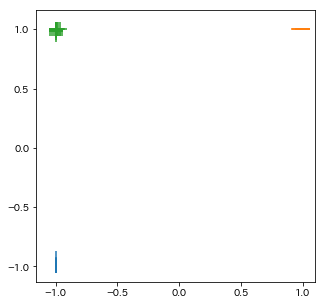

In [9]:
hidden2_vals = sess.run(hidden2, feed_dict={x:images})

z1_vals = [[],[],[]]
z2_vals = [[],[],[]]

for hidden2_val, label in zip(hidden2_vals, labels):
    label_num = np.argmax(label)
    z1_vals[label_num].append(hidden2_val[0])
    z2_vals[label_num].append(hidden2_val[1])
    
fig = plt.figure(figsize=(5,5))
subplot = fig.add_subplot(1,1,1)
subplot.scatter(z1_vals[0], z2_vals[0], s=200, marker='|')
subplot.scatter(z1_vals[1], z2_vals[1], s=200, marker='_')
subplot.scatter(z1_vals[2], z2_vals[2], s=200, marker='+')

# Keras

In [10]:
from keras.models import Sequential
from keras.layers.core import Activation, Lambda, Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.models import Model

Using TensorFlow backend.


In [11]:
def weight_init(shape, dtype=None):
#def weight_init():
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5,5,1,2])
    filter_array[:,:,0,0] = filter0
    filter_array[:,:,0,1] = filter1

    print("filter shape: ",  filter_array.shape)
    return filter_array

In [12]:
model = Sequential()

In [13]:
model.add(Conv2D(filters=2, kernel_size=5,
                 padding="same",
                 data_format="channels_last",
                 use_bias=False,
                 input_shape=(28, 28, 1),
                kernel_initializer=weight_init,
                trainable=False
                ))
model.add(Lambda(lambda x: x - 0.2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),
                       padding="same", 
                       data_format="channels_last"))
model.add(Flatten())  #  入力を平滑化する．バッチサイズに影響されない．
model.add(Dense(units=2))
model.add(Activation('tanh', name='hidden'))
model.add(Dense(units=3))
model.add(Activation('softmax'))

model.summary()

filter shape:  (5, 5, 1, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 2)         50        
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 2)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 2)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 2)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 786       
_________________________________________________________________
hidden (Activation)          (None, 2)          

In [14]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [15]:
x = np.array(images)
x = x.reshape([-1,28,28,1])
x.shape

(90, 28, 28, 1)

In [16]:
# 学習
hist = model.fit(x, labels, batch_size=x.shape[0], epochs=200)

Epoch 1/200
90/90 [==============================] - 0s 5ms/step - loss: 1.1255 - acc: 0.5222
Epoch 2/200
90/90 [==============================] - 0s 148us/step - loss: 1.1190 - acc: 0.5556
Epoch 3/200
90/90 [==============================] - 0s 178us/step - loss: 1.1125 - acc: 0.5444
Epoch 4/200
90/90 [==============================] - 0s 181us/step - loss: 1.1061 - acc: 0.5556
Epoch 5/200
90/90 [==============================] - 0s 187us/step - loss: 1.0997 - acc: 0.5667
Epoch 6/200
90/90 [==============================] - 0s 225us/step - loss: 1.0934 - acc: 0.5667
Epoch 7/200
90/90 [==============================] - 0s 180us/step - loss: 1.0871 - acc: 0.5667
Epoch 8/200
90/90 [==============================] - 0s 187us/step - loss: 1.0810 - acc: 0.6111
Epoch 9/200
90/90 [==============================] - 0s 317us/step - loss: 1.0748 - acc: 0.6333
Epoch 10/200
90/90 [==============================] - 0s 208us/step - loss: 1.0687 - acc: 0.6333
Epoch 11/200
90/90 [=====================

Epoch 86/200
90/90 [==============================] - 0s 151us/step - loss: 0.7618 - acc: 0.9111
Epoch 87/200
90/90 [==============================] - 0s 158us/step - loss: 0.7590 - acc: 0.9111
Epoch 88/200
90/90 [==============================] - 0s 157us/step - loss: 0.7562 - acc: 0.9222
Epoch 89/200
90/90 [==============================] - 0s 211us/step - loss: 0.7533 - acc: 0.9222
Epoch 90/200
90/90 [==============================] - 0s 190us/step - loss: 0.7505 - acc: 0.9333
Epoch 91/200
90/90 [==============================] - 0s 152us/step - loss: 0.7478 - acc: 0.9333
Epoch 92/200
90/90 [==============================] - 0s 178us/step - loss: 0.7450 - acc: 0.9444
Epoch 93/200
90/90 [==============================] - 0s 188us/step - loss: 0.7422 - acc: 0.9556
Epoch 94/200
90/90 [==============================] - 0s 169us/step - loss: 0.7395 - acc: 0.9667
Epoch 95/200
90/90 [==============================] - 0s 230us/step - loss: 0.7367 - acc: 0.9889
Epoch 96/200
90/90 [==========

Epoch 170/200
90/90 [==============================] - 0s 195us/step - loss: 0.5654 - acc: 1.0000
Epoch 171/200
90/90 [==============================] - 0s 209us/step - loss: 0.5635 - acc: 1.0000
Epoch 172/200
90/90 [==============================] - 0s 169us/step - loss: 0.5617 - acc: 1.0000
Epoch 173/200
90/90 [==============================] - 0s 177us/step - loss: 0.5599 - acc: 1.0000
Epoch 174/200
90/90 [==============================] - 0s 190us/step - loss: 0.5580 - acc: 1.0000
Epoch 175/200
90/90 [==============================] - 0s 239us/step - loss: 0.5562 - acc: 1.0000
Epoch 176/200
90/90 [==============================] - 0s 200us/step - loss: 0.5544 - acc: 1.0000
Epoch 177/200
90/90 [==============================] - 0s 239us/step - loss: 0.5527 - acc: 1.0000
Epoch 178/200
90/90 [==============================] - 0s 185us/step - loss: 0.5509 - acc: 1.0000
Epoch 179/200
90/90 [==============================] - 0s 166us/step - loss: 0.5491 - acc: 1.0000
Epoch 180/200
90/90 

In [17]:
model.get_layer('hidden')

In [18]:
model.input

<tf.Tensor 'conv2d_1_input:0' shape=(?, 28, 28, 1) dtype=float32>

In [19]:
model.get_layer('hidden').output

<tf.Tensor 'hidden/Tanh:0' shape=(?, 2) dtype=float32>

In [20]:
# 中間層の出力を得るためには新たなModel を作成
layer_name = 'hidden'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output) # 入力がinputで出力層は欲しい中間層のTensor
intermediate_output = intermediate_layer_model.predict(x)

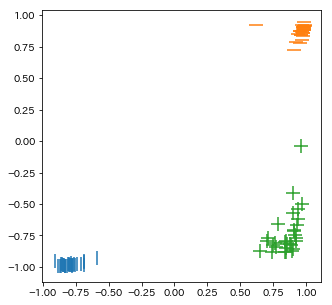

In [21]:
hidden2_vals = intermediate_output

z1_vals = [[],[],[]]
z2_vals = [[],[],[]] 

for hidden2_val, label in zip(hidden2_vals, labels):
    label_num = np.argmax(label)
    z1_vals[label_num].append(hidden2_val[0])
    z2_vals[label_num].append(hidden2_val[1])
    
fig = plt.figure(figsize=(5,5))
subplot = fig.add_subplot(1,1,1)
subplot.scatter(z1_vals[0], z2_vals[0], s=200, marker='|')
subplot.scatter(z1_vals[1], z2_vals[1], s=200, marker='_')
subplot.scatter(z1_vals[2], z2_vals[2], s=200, marker='+')